In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb 
import catboost as ctb
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/msbd5001-fall2020/test.csv
/kaggle/input/msbd5001-fall2020/train.csv
/kaggle/input/msbd5001-fall2020/sampleSubmission.csv


In [2]:
from sklearn.model_selection import KFold, TimeSeriesSplit
random_state = 2020
num_fold = 5

In [3]:
sample_submission_df = pd.read_csv("/kaggle/input/msbd5001-fall2020/sampleSubmission.csv")
sample_submission_df.shape

(3504, 2)

In [4]:
train_df = pd.read_csv("/kaggle/input/msbd5001-fall2020/train.csv")
test_df = pd.read_csv("/kaggle/input/msbd5001-fall2020/test.csv")
train_df.date = pd.to_datetime(train_df.date, format='%d/%m/%Y %H:%M').dt.tz_localize("HongKong")
test_df.date = pd.to_datetime(test_df.date, format='%d/%m/%Y %H:%M').dt.tz_localize("HongKong")
train_df.shape, test_df.shape

((14006, 3), (3504, 2))

In [5]:
holidays =[
    "2017-1-1",
    "2017-1-2",
    "2017-1-28",
    "2017-1-30",
    "2017-1-31",
    "2017-4-4",
    "2017-4-14",
    "2017-4-15",
    "2017-4-17",
    "2017-5-1",
    "2017-5-3",
    "2017-5-30",
    "2017-7-1",
    "2017-10-1",
    "2017-10-2",
    "2017-10-5",
    "2017-10-28",
    "2017-12-25",
    "2017-12-26",
    "2018-1-1",
    "2018-2-16",
    "2018-2-17",
    "2018-2-19",
    "2018-3-30",
    "2018-3-31",
    "2018-4-2",
    "2018-4-5",
    "2018-5-1",
    "2018-5-22",
    "2018-6-18",
    "2018-7-1",
    "2018-7-2",
    "2018-9-24",
    "2018-9-25",
    "2018-10-1",
    "2018-10-17",
    "2018-12-25",
    "2018-12-26",
]
holidays = [pd.to_datetime(h, format='%Y-%m-%d').tz_localize("HongKong") for h in holidays]
holidays

[Timestamp('2017-01-01 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-01-02 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-01-28 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-01-30 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-01-31 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-04-04 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-04-14 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-04-15 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-04-17 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-05-01 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-05-03 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-05-30 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-07-01 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-10-01 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-10-02 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-10-05 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-10-28 00:00:00+0800', tz='Hongkong'),
 Timestamp('2017-12-25 00:00:00+0800', tz='Hongkong'),
 Timestamp

In [6]:
train_df.date.dt.floor('d').isin(holidays).mean()

0.051763529915750395

In [7]:
test_df.date.dt.floor('d').isin(holidays).mean()

0.0533675799086758

# Check Missing DateTime

Apart from the testing data, there are other missing datetime.

In [8]:
test_df["is_test"] = True
train_df["is_test"] = False

all_df = pd.concat([train_df, test_df], ignore_index=True).sort_values("date").reset_index(drop=True)

all_df["lag_date"] = all_df["date"].shift()
all_df["interval"] = (all_df["date"] - all_df["lag_date"])

In [9]:
all_df.interval.value_counts()

0 days 01:00:00    17506
0 days 06:00:00        1
0 days 02:00:00        1
0 days 05:00:00        1
Name: interval, dtype: int64

In [10]:
train_df["lag_date"] = train_df["date"].shift()
train_df["interval"] = (train_df["date"] - train_df["lag_date"])
train_df.head()

,id,date,speed,is_test,lag_date,interval
0,0,2017-01-01 00:00:00+08:00,43.002930,False,NaT,NaT
1,1,2017-01-01 01:00:00+08:00,46.118696,False,2017-01-01 00:00:00+08:00,0 days 01:00:00
2,2,2017-01-01 02:00:00+08:00,44.294158,False,2017-01-01 01:00:00+08:00,0 days 01:00:00
3,3,2017-01-01 03:00:00+08:00,41.067468,False,2017-01-01 02:00:00+08:00,0 days 01:00:00
4,4,2017-01-01 04:00:00+08:00,46.448653,False,2017-01-01 03:00:00+08:00,0 days 01:00:00


In [11]:
train_df[train_df.date.dt.year==2018].interval.value_counts()

0 days 01:00:00    3135
0 days 02:00:00    1260
0 days 03:00:00     526
0 days 04:00:00     217
0 days 05:00:00      75
0 days 06:00:00      30
0 days 07:00:00       8
0 days 10:00:00       2
0 days 08:00:00       2
0 days 09:00:00       1
Name: interval, dtype: int64

# Create an Ideal dataframe with all datetime

We can treat the missing data in 2017 similar to the test data in 2018

In [12]:
print(all_df.date.min(), all_df.date.max())
print(all_df[all_df.date.dt.year==2017].date.min(), all_df[all_df.date.dt.year==2017].date.max())
print(all_df[all_df.date.dt.year==2018].date.min(), all_df[all_df.date.dt.year==2018].date.max())
all_df.head()

2017-01-01 00:00:00+08:00 2018-12-31 23:00:00+08:00
2017-01-01 00:00:00+08:00 2017-12-31 23:00:00+08:00
2018-01-01 00:00:00+08:00 2018-12-31 23:00:00+08:00


,id,date,speed,is_test,lag_date,interval
0,0,2017-01-01 00:00:00+08:00,43.002930,False,NaT,NaT
1,1,2017-01-01 01:00:00+08:00,46.118696,False,2017-01-01 00:00:00+08:00,0 days 01:00:00
2,2,2017-01-01 02:00:00+08:00,44.294158,False,2017-01-01 01:00:00+08:00,0 days 01:00:00
3,3,2017-01-01 03:00:00+08:00,41.067468,False,2017-01-01 02:00:00+08:00,0 days 01:00:00
4,4,2017-01-01 04:00:00+08:00,46.448653,False,2017-01-01 03:00:00+08:00,0 days 01:00:00


In [13]:
ideal_date = pd.period_range(start="2017-01-01 00:00:00", end="2018-12-31 23:00:00", freq="H")
print(ideal_date.dtype)
ideal_df = pd.DataFrame({
    "date": ideal_date.to_timestamp(),
})
ideal_df["date"] = ideal_df["date"].dt.tz_localize("HongKong")

print(ideal_df.date.min(), ideal_df.date.max())
print(ideal_df[ideal_df.date.dt.year==2017].date.min(), ideal_df[ideal_df.date.dt.year==2017].date.max())
print(ideal_df[ideal_df.date.dt.year==2018].date.min(), ideal_df[ideal_df.date.dt.year==2018].date.max())

period[H]
2017-01-01 00:00:00+08:00 2018-12-31 23:00:00+08:00
2017-01-01 00:00:00+08:00 2017-12-31 23:00:00+08:00
2018-01-01 00:00:00+08:00 2018-12-31 23:00:00+08:00


In [14]:
full_df = pd.merge(ideal_df, all_df, on="date", how="left")
full_df.head(5)

,date,id,speed,is_test,lag_date,interval
0,2017-01-01 00:00:00+08:00,0.0,43.002930,False,NaT,NaT
1,2017-01-01 01:00:00+08:00,1.0,46.118696,False,2017-01-01 00:00:00+08:00,0 days 01:00:00
2,2017-01-01 02:00:00+08:00,2.0,44.294158,False,2017-01-01 01:00:00+08:00,0 days 01:00:00
3,2017-01-01 03:00:00+08:00,3.0,41.067468,False,2017-01-01 02:00:00+08:00,0 days 01:00:00
4,2017-01-01 04:00:00+08:00,4.0,46.448653,False,2017-01-01 03:00:00+08:00,0 days 01:00:00


In [15]:
full_df["lag_date"] = full_df["date"].shift()
full_df["interval"] = (full_df["date"] - full_df["lag_date"])
full_df["interval"].value_counts()

0 days 01:00:00    17519
Name: interval, dtype: int64

In [16]:
print(full_df["is_test"].isna().sum())
# Treat newly created missing time step as testing/unseen data.
# full_df["is_test"] = full_df["is_test"].fillna(True)

10


In [17]:
full_df = full_df[["date", "id", "speed", "is_test"]]
full_df.head()

,date,id,speed,is_test
0,2017-01-01 00:00:00+08:00,0.0,43.002930,False
1,2017-01-01 01:00:00+08:00,1.0,46.118696,False
2,2017-01-01 02:00:00+08:00,2.0,44.294158,False
3,2017-01-01 03:00:00+08:00,3.0,41.067468,False
4,2017-01-01 04:00:00+08:00,4.0,46.448653,False


In [18]:
full_df[full_df.date.dt.year==2017]["speed"].isna().sum(), full_df[full_df.date.dt.year==2018]["speed"].isna().sum()

(10, 3504)

In [19]:
full_df.shape

(17520, 4)

# Simulate the missing distrution in 2018 to 2017
It is hard to generate stable features, especially rolling statistics in 2017 that similar to features in 2018, because there are many missing data in 2018.
Therefore, we are making holes in 2017 data as well

In [20]:
# TODO
full_df = full_df[~full_df.is_test.isna()]
full_df["id"] = full_df["id"].astype(int)
print(full_df.shape)

(17510, 4)


In [21]:
full_2017_df = full_df[full_df.date.dt.year==2017].reset_index(drop=True)
full_2018_df = full_df[full_df.date.dt.year==2018].reset_index(drop=True)
full_2017_df.shape, full_2018_df.shape

((8750, 4), (8760, 4))

In [22]:
date_holes = full_2017_df.sample(frac=3504/full_2018_df.shape[0], random_state=random_state).date
date_holes

4289   2017-06-29 02:00:00+08:00
2356   2017-04-09 13:00:00+08:00
7659   2017-11-16 13:00:00+08:00
5737   2017-08-28 11:00:00+08:00
2041   2017-03-27 10:00:00+08:00
                  ...           
4919   2017-07-25 09:00:00+08:00
576    2017-01-25 09:00:00+08:00
1519   2017-03-05 16:00:00+08:00
2598   2017-04-19 15:00:00+08:00
1712   2017-03-13 17:00:00+08:00
Name: date, Length: 3500, dtype: datetime64[ns, Hongkong]

In [23]:
full_2017_df["truth"] = full_2017_df.speed
full_2017_df.loc[full_2017_df.date.isin(date_holes), "speed"] = np.nan
full_2017_df["speed"].isna().sum()

3500

Now 2017 have similar missing data in 2018

In [24]:
temp_df = full_2017_df[~full_2017_df.speed.isna()].reset_index(drop=True)
temp_df["lag_date"] = temp_df["date"].shift()
temp_df["interval"] = (temp_df["date"] - temp_df["lag_date"])
temp_df[temp_df.date.dt.year == 2017]["interval"].value_counts()


# 2018 interval distribution:
# 0 days 01:00:00    3135
# 0 days 02:00:00    1260
# 0 days 03:00:00     526
# 0 days 04:00:00     217
# 0 days 05:00:00      75
# 0 days 06:00:00      30
# 0 days 07:00:00       8
# 0 days 10:00:00       2
# 0 days 08:00:00       2
# 0 days 09:00:00       1
# Name: interval, dtype: int64

0 days 01:00:00    3183
0 days 02:00:00    1206
0 days 03:00:00     515
0 days 04:00:00     198
0 days 05:00:00      90
0 days 06:00:00      40
0 days 08:00:00       6
0 days 07:00:00       6
0 days 09:00:00       4
0 days 11:00:00       1
Name: interval, dtype: int64

In [25]:
full_2018_df["truth"] = full_2018_df.speed
full_df = pd.concat([full_2017_df, full_2018_df], ignore_index=True)

# Preprocessing

In [26]:
def preprocessing(df: pd.DataFrame, speed_feature="speed"):
    
    
    # % change
    for lag in [1, 2, 3]:
        df[f"Prev_{lag}_%_change"] = df["per_change"].shift() 
    
    # Prev/Post hours speed compareing to their weekday_hour average
    for lag in [1, 2, 3, 24]:
        df[f"Prev_{lag}_{speed_feature}"] = df[speed_feature].shift(lag)
        df[f"Post_{lag}_{speed_feature}"] = df[speed_feature].shift(-lag)
           
        df[f"Prev_{lag}_weekday_hour_mean"] = df["weekday_hour_avg_speed"].shift(lag)
        df[f"Post_{lag}_weekday_hour_mean"] = df["weekday_hour_avg_speed"].shift(-lag)
        
        df[f"Prev_{lag}_weekday_hour_std"] = df["weekday_hour_std_speed"].shift(lag)
        df[f"Post_{lag}_weekday_hour_std"] = df["weekday_hour_std_speed"].shift(-lag)
        
        
        # Prev/Post speed compare to Prev/Post mean spped
        df[f"Ratio_Prev_{lag}_weekday_hour_mean"] = df[f"Prev_{lag}_{speed_feature}"] / df[f"Prev_{lag}_weekday_hour_mean"]
        df[f"Ratio_Post_{lag}_weekday_hour_mean"] = df[f"Post_{lag}_{speed_feature}"] / df[f"Post_{lag}_weekday_hour_mean"]
        
        df[f"PDiff_Prev_{lag}_weekday_hour_mean"] = (df[f"Prev_{lag}_{speed_feature}"] - df[f"Prev_{lag}_weekday_hour_mean"]) / df[f"Prev_{lag}_weekday_hour_mean"]
        df[f"PDiff_Post_{lag}_weekday_hour_mean"] = (df[f"Post_{lag}_{speed_feature}"] - df[f"Post_{lag}_weekday_hour_mean"]) / df[f"Post_{lag}_weekday_hour_mean"]
        
        df[f"Z_Score_Prev_{lag}_weekday_hour"] = (df[f"Prev_{lag}_{speed_feature}"] - df[f"Prev_{lag}_weekday_hour_mean"]) / df[f"Prev_{lag}_weekday_hour_std"]
        df[f"Z_Score_Post_{lag}_weekday_hour"] = (df[f"Post_{lag}_{speed_feature}"] - df[f"Post_{lag}_weekday_hour_mean"]) / df[f"Post_{lag}_weekday_hour_std"]
    
    # % change between prevs & posts
    for lag in [3]:
        df[f"PDiff_Prev_1_{lag}"] = (df[f"Prev_{lag}_{speed_feature}"] - df[f"Prev_1_{speed_feature}"]) / df[f"Prev_{lag}_{speed_feature}"]
        

    # Prev/Post Moving simple statistics
    for win in [3, 5, 10]:
        df[f"Prev_{win}_Avg_{speed_feature}"] = df[speed_feature].shift().rolling(win, win_type=None, min_periods=1).mean()
        df[f"Prev_{win}_Max_{speed_feature}"] = df[speed_feature].shift().rolling(win, win_type=None, min_periods=1).max()
        df[f"Prev_{win}_Min_{speed_feature}"] = df[speed_feature].shift().rolling(win, win_type=None, min_periods=1).min()
        
        df[f"Post_{win}_Avg_{speed_feature}"] = df[f"Prev_{win}_Avg_{speed_feature}"].shift(-win-1)
        df[f"Post_{win}_Max_{speed_feature}"] = df[f"Prev_{win}_Max_{speed_feature}"].shift(-win-1)
        df[f"Post_{win}_Min_{speed_feature}"] = df[f"Prev_{win}_Min_{speed_feature}"].shift(-win-1)
    
        df[f"Ratio_Prev_2_{win}_Avg"] = df[f"Prev_2_{speed_feature}"] / (df[f"Prev_{win}_Avg_{speed_feature}"])
        
        df[f"Prev_{win}_EMA_{speed_feature}"] = df[speed_feature].shift().ewm(win, min_periods=1, ignore_na=True).mean()
    
    # Prev/Post Moving groupby statistics
#     for win in [3, 5]:
#         df[f"Prev_{win}_Avg_hourly_{speed_feature}"] = full_df.groupby("weekday_hour")[speed_feature].shift().rolling(win, min_periods=1).median()
# #         df[f"Post_{win}_Avg_hourly_{speed_feature}"] = df[f"Prev_{win}_Avg_hourly_{speed_feature}"].shift(-win-1)
    
    
    display(df.head(5))
    return df

In [27]:
full_df["month"] = full_df.date.dt.month
full_df["day"] = full_df.date.dt.day
full_df["hour"] = full_df.date.dt.hour # 24
full_df["weekday"] = full_df.date.dt.weekday # 7
full_df["dayofyear"] = full_df.date.dt.dayofyear
full_df["weekofyear"] = full_df.date.dt.weekofyear

full_df["holiday"] = full_df.date.dt.floor('d').isin(holidays)
print("holiday", full_df["holiday"].mean())

# sun -> 6 
full_df.loc[full_df["weekday"]==0, "weekday"] = 7
full_df["weekday"] -= 1

full_df["weekday_hour"] = full_df["weekday"] * 24 + full_df["hour"]
full_df["day_weekday_hour"] = (full_df["day"]//7) * (7*24) + full_df["weekday"] * 24 + full_df["hour"]
full_df["quarter"] = full_df.date.dt.quarter
full_df["year_weekday_hour"] = full_df.date.dt.year + full_df["weekday"] * 24 + full_df["hour"]

full_df = full_df.sort_values("date").reset_index(drop=True)

full_df["speed_fill_median"] = full_df.groupby("weekday_hour")["speed"].transform("median")
full_df.loc[~full_df.speed.isna(), "speed_fill_median"] = full_df.loc[~full_df.speed.isna(), "speed"] 


full_df["hour_avg_speed"] = full_df.groupby("hour")["truth"].transform("mean")
full_df["hour_std_speed"] = full_df.groupby("hour")["truth"].transform("std")

full_df["weekday_hour_avg_speed"] = full_df.groupby(["weekday_hour"])["truth"].transform("mean")
full_df["weekday_hour_std_speed"] = full_df.groupby(["weekday_hour"])["truth"].transform("std")


    
full_df["per_change"] = full_df["speed"].pct_change()



full_df = preprocessing(full_df, "speed_fill_median")

holiday 0.05208452312964021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,date,id,speed,is_test,truth,month,day,hour,weekday,dayofyear,...,Ratio_Prev_2_5_Avg,Prev_5_EMA_speed_fill_median,Prev_10_Avg_speed_fill_median,Prev_10_Max_speed_fill_median,Prev_10_Min_speed_fill_median,Post_10_Avg_speed_fill_median,Post_10_Max_speed_fill_median,Post_10_Min_speed_fill_median,Ratio_Prev_2_10_Avg,Prev_10_EMA_speed_fill_median
0,2017-01-01 00:00:00+08:00,0,43.002930,False,43.002930,1,1,0,5,1,...,NaN,NaN,NaN,NaN,NaN,44.865575,47.482253,40.390623,NaN,NaN
1,2017-01-01 01:00:00+08:00,1,NaN,False,46.118696,1,1,1,5,1,...,NaN,43.002930,43.002930,43.002930,43.00293,44.132610,47.430576,40.152604,NaN,43.002930
2,2017-01-01 02:00:00+08:00,2,44.294158,False,44.294158,1,1,2,5,1,...,0.950497,45.446197,45.242592,47.482253,43.00293,43.975668,47.430576,40.152604,0.950497,45.349242
3,2017-01-01 03:00:00+08:00,3,NaN,False,41.067468,1,1,3,5,1,...,1.056889,44.990445,44.926447,47.482253,43.00293,44.026256,47.936459,40.152604,1.056889,44.963547
4,2017-01-01 04:00:00+08:00,4,46.448653,False,46.448653,1,1,4,5,1,...,0.972376,45.775942,45.552479,47.482253,43.00293,43.623007,47.936459,40.152604,0.972376,45.671070


In [28]:
full_df["year_weekday_hour"]

0        2137
1        2138
2        2139
3        2140
4        2141
         ... 
17505    2181
17506    2182
17507    2183
17508    2184
17509    2185
Name: year_weekday_hour, Length: 17510, dtype: int64

In [29]:
full_df["date_only"] = full_df.date.dt.floor("d")
full_df["daily_min"] = full_df.groupby("date_only")["truth"].transform("min")
full_df["daily_max"] = full_df.groupby("date_only")["truth"].transform("max")

peak_hours = full_df[full_df["truth"] == full_df["daily_max"]].groupby("weekday").hour.mean()
low_hours = full_df[full_df["truth"] == full_df["daily_min"]].groupby("weekday").hour.mean()
peak_hours, low_hours

(weekday
 0    2.298077
 1    2.057692
 2    1.894231
 3    1.788462
 4    2.365385
 5    4.657143
 6    2.904762
 Name: hour, dtype: float64,
 weekday
 0    15.557692
 1    15.894231
 2    16.605769
 3    16.355769
 4    15.288462
 5    17.828571
 6    16.514286
 Name: hour, dtype: float64)

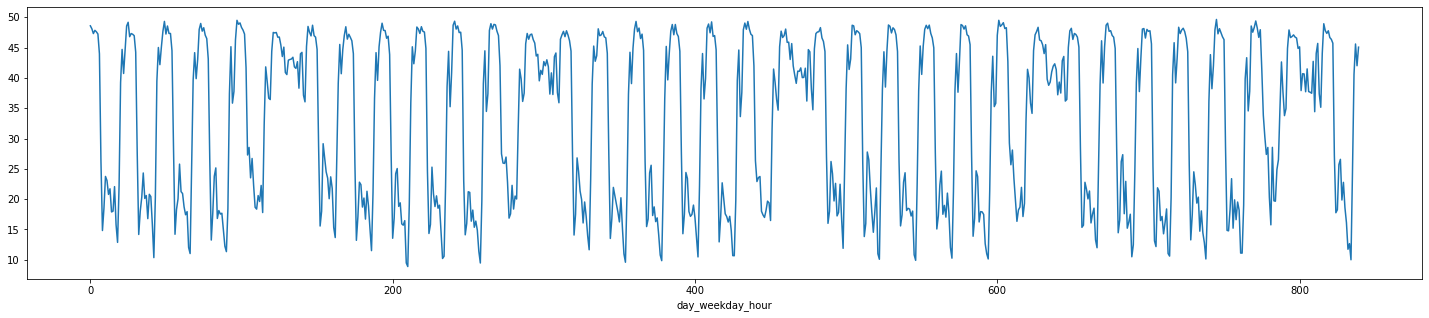

In [30]:
full_df.groupby("day_weekday_hour")["speed"].median().plot(figsize=(25,5))

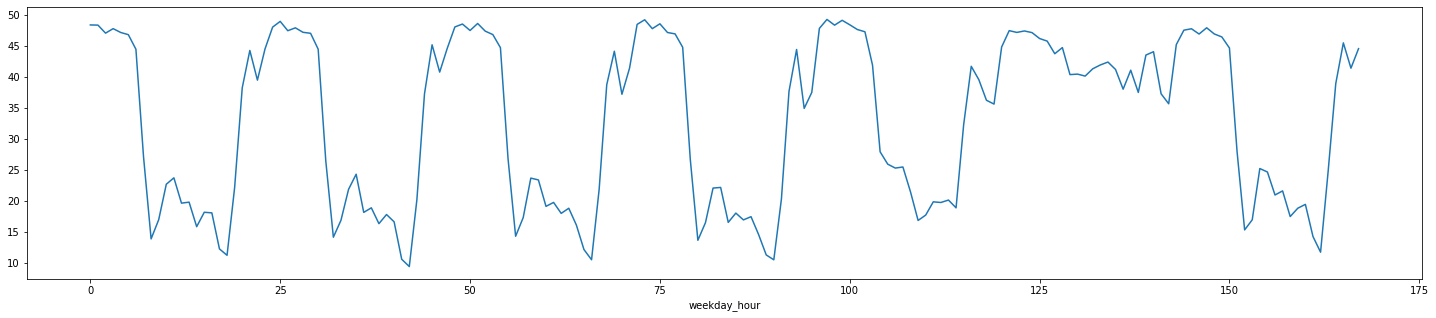

In [31]:
full_df.groupby("weekday_hour")["speed"].median().plot(figsize=(25,5))

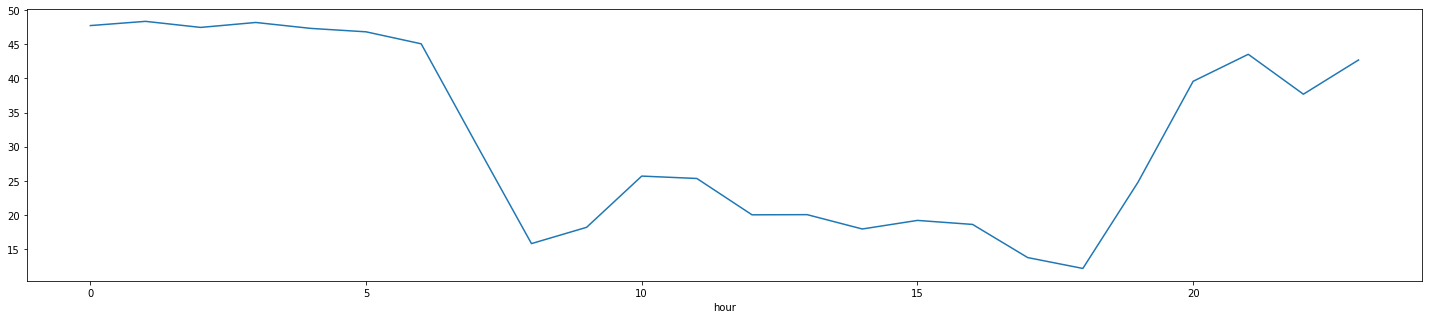

In [32]:
full_df.groupby("hour")["speed"].median().plot(figsize=(25,5))

# Setup Validation Data

In [33]:
train_df = full_df[~full_df.speed.isna()].reset_index(drop=True)
valid_df_2017 = full_df[(full_df.speed.isna()) & (full_df.date.dt.year==2017)].reset_index(drop=True)
valid_df_2018 = full_df[(~full_df.speed.isna()) & (full_df.date.dt.year==2018)].reset_index(drop=True)

train_df.shape, valid_df_2017.shape, valid_df_2018.shape

((10506, 101), (3500, 101), (5256, 101))

In [34]:
train_df["holiday"].mean(), valid_df_2017["holiday"].mean(), valid_df_2018["holiday"].mean()

(0.05111364934323244, 0.053714285714285714, 0.05117960426179604)

In [35]:
train_df.truth.isna().sum(), valid_df_2017.truth.isna().sum(),  valid_df_2018.truth.isna().sum()

(0, 0, 0)

In [36]:
test_df = full_df[(full_df.speed.isna()) & (full_df.date.dt.year==2018)].reset_index(drop=True)
test_df.shape

(3504, 101)

In [37]:
test_df.head()

,date,id,speed,is_test,truth,month,day,hour,weekday,dayofyear,...,Prev_10_Max_speed_fill_median,Prev_10_Min_speed_fill_median,Post_10_Avg_speed_fill_median,Post_10_Max_speed_fill_median,Post_10_Min_speed_fill_median,Ratio_Prev_2_10_Avg,Prev_10_EMA_speed_fill_median,date_only,daily_min,daily_max
0,2018-01-01 02:00:00+08:00,0,NaN,True,NaN,1,1,2,6,1,...,47.648155,35.688279,35.915872,50.626977,15.351863,1.029970,42.248563,2018-01-01 00:00:00+08:00,17.453598,50.626977
1,2018-01-01 05:00:00+08:00,1,NaN,True,NaN,1,1,5,6,1,...,50.626977,35.688279,30.684703,46.179884,15.351863,1.116431,43.883367,2018-01-01 00:00:00+08:00,17.453598,50.626977
2,2018-01-01 07:00:00+08:00,2,NaN,True,NaN,1,1,7,6,1,...,50.626977,35.688279,26.955650,36.009622,15.351863,1.021299,44.305368,2018-01-01 00:00:00+08:00,17.453598,50.626977
3,2018-01-01 08:00:00+08:00,3,NaN,True,NaN,1,1,8,6,1,...,50.626977,28.028857,26.595991,36.009622,11.755274,1.049748,42.825685,2018-01-01 00:00:00+08:00,17.453598,50.626977
4,2018-01-01 10:00:00+08:00,4,NaN,True,NaN,1,1,10,6,1,...,50.626977,15.351863,28.137377,41.567309,11.755274,0.374717,39.935479,2018-01-01 00:00:00+08:00,17.453598,50.626977


In [38]:
selected_features = [col for col in train_df.columns if col not in ["id", "date", "per_change", "daily_max", "daily_min",
                                                                    "day_weekday_hour",
                                                                    "date_only",
                                                                    "year_weekday_hour",
                                                                    "speed_fill",
                                                                    "speed_fill_median_h",
                                                                    "speed_fill_median_wh",
                                                                    "speed_fill_mean_h",
                                                                    "speed_fill_mean_wh",
                                                                    "speed_fill_mean",
                                                                    "speed_fill_median", 
                                                                    "speed_fill_wh_median",
                                                                    "lin_speed", "quadratic_speed", "nearest_speed", "speed", "is_test", "truth"]]
from pprint import pprint
pprint(selected_features)

['month',
 'day',
 'hour',
 'weekday',
 'dayofyear',
 'weekofyear',
 'holiday',
 'weekday_hour',
 'quarter',
 'hour_avg_speed',
 'hour_std_speed',
 'weekday_hour_avg_speed',
 'weekday_hour_std_speed',
 'Prev_1_%_change',
 'Prev_2_%_change',
 'Prev_3_%_change',
 'Prev_1_speed_fill_median',
 'Post_1_speed_fill_median',
 'Prev_1_weekday_hour_mean',
 'Post_1_weekday_hour_mean',
 'Prev_1_weekday_hour_std',
 'Post_1_weekday_hour_std',
 'Ratio_Prev_1_weekday_hour_mean',
 'Ratio_Post_1_weekday_hour_mean',
 'PDiff_Prev_1_weekday_hour_mean',
 'PDiff_Post_1_weekday_hour_mean',
 'Z_Score_Prev_1_weekday_hour',
 'Z_Score_Post_1_weekday_hour',
 'Prev_2_speed_fill_median',
 'Post_2_speed_fill_median',
 'Prev_2_weekday_hour_mean',
 'Post_2_weekday_hour_mean',
 'Prev_2_weekday_hour_std',
 'Post_2_weekday_hour_std',
 'Ratio_Prev_2_weekday_hour_mean',
 'Ratio_Post_2_weekday_hour_mean',
 'PDiff_Prev_2_weekday_hour_mean',
 'PDiff_Post_2_weekday_hour_mean',
 'Z_Score_Prev_2_weekday_hour',
 'Z_Score_Post_2_we

In [39]:
train_df[selected_features].isna().mean(), valid_df_2017[selected_features].isna().mean(), valid_df_2018[selected_features].isna().mean(), test_df[selected_features].isna().mean()

(month                            0.000000
 day                              0.000000
 hour                             0.000000
 weekday                          0.000000
 dayofyear                        0.000000
                                    ...   
 Post_10_Avg_speed_fill_median    0.000381
 Post_10_Max_speed_fill_median    0.000381
 Post_10_Min_speed_fill_median    0.000381
 Ratio_Prev_2_10_Avg              0.000095
 Prev_10_EMA_speed_fill_median    0.000095
 Length: 89, dtype: float64,
 month                            0.000000
 day                              0.000000
 hour                             0.000000
 weekday                          0.000000
 dayofyear                        0.000000
                                    ...   
 Post_10_Avg_speed_fill_median    0.000000
 Post_10_Max_speed_fill_median    0.000000
 Post_10_Min_speed_fill_median    0.000000
 Ratio_Prev_2_10_Avg              0.000286
 Prev_10_EMA_speed_fill_median    0.000000
 Length: 89, dtype: float

In [40]:
print(test_df.shape)

for col in selected_features:
    avg = train_df[col].mean()
    print(col, avg)
    for df in [train_df, test_df, valid_df_2017, valid_df_2018]:
        df[col] = df[col].fillna(avg)
        print(df[col].isna().sum())
print(test_df.shape)

(3504, 101)
month 6.453931086997906
0
0
0
0
day 15.68665524462212
0
0
0
0
hour 11.56986483913954
0
0
0
0
weekday 3.0322672758423757
0
0
0
0
dayofyear 180.77184466019418
0
0
0
0
weekofyear 26.183609366076528
0
0
0
0
holiday 0.05111364934323244
0
0
0
0
weekday_hour 84.34427945935656
0
0
0
0
quarter 2.486483913953931
0
0
0
0
hour_avg_speed 32.80101429724892
0
0
0
0
hour_std_speed 6.410054506499643
0
0
0
0
weekday_hour_avg_speed 32.82769497925078
0
0
0
0
weekday_hour_std_speed 3.7630571491891796
0
0
0
0
Prev_1_%_change 0.05754094807253578
0
0
0
0
Prev_2_%_change 0.05754094807253578
0
0
0
0
Prev_3_%_change 0.05754094807253578
0
0
0
0
Prev_1_speed_fill_median 32.84461149446705
0
0
0
0
Post_1_speed_fill_median 32.90313856506237
0
0
0
0
Prev_1_weekday_hour_mean 32.78830480301919
0
0
0
0
Post_1_weekday_hour_mean 32.8526385930843
0
0
0
0
Prev_1_weekday_hour_std 3.763020538630843
0
0
0
0
Post_1_weekday_hour_std 3.7555091293504796
0
0
0
0
Ratio_Prev_1_weekday_hour_mean 1.0002888509659753
0
0
0
0
R

In [41]:
import tensorflow as tf
import tensorflow_addons as tfa
import gc
from math import pi
from math import cos
from math import floor

class CosineAnnealingLearningRateSchedule(tf.keras.callbacks.Callback):
	# constructor
	def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
		self.epochs = n_epochs
		self.cycles = n_cycles
		self.lr_max = lrate_max
		self.lrates = list()
 
	# calculate learning rate for an epoch
	def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
		epochs_per_cycle = floor(n_epochs/n_cycles)
		cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
		return lrate_max/2 * (cos(cos_inner) + 1)
 
	# calculate and set learning rate at the start of the epoch
	def on_epoch_begin(self, epoch, logs=None):
		# calculate learning rate
		lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
		# set learning rate
		tf.keras.backend.set_value(self.model.optimizer.lr, lr)
		# log value
		self.lrates.append(lr)

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from typing import Callable, List
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, BayesianRidge, Lasso, HuberRegressor, ElasticNet, Lars
from sklearn.svm import LinearSVR, SVR, NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, BaggingRegressor

def train(model_builder: Callable, features: List[str], scaling=True, one_hot_features=[]):
    all_train_preds = np.array([])
    all_train_y = np.array([])
    
    all_valid_preds_2017 = np.array([])
    all_valid_y_2017 = np.array([])
    all_valid_preds_2018 = np.array([])
    all_valid_y_2018 = np.array([])
    
    all_test_preds = 0
    
    models = []
    num_fold = 1
    feature_importance = None
    
    for fold in range(num_fold):
        print("#"*5, f"Fold-{fold}", "#"*5)
        print(train_df["date"].dt.year.value_counts())
        _train_df = train_df.copy()
        _valid_df_2017 = valid_df_2017.copy()
        _valid_df_2018 = valid_df_2018.copy()
        
        _features = features.copy()
        _features = [f for f in _features if f not in one_hot_features]
        
        train_ohe = {}
        valid_2017_ohe = {}
        valid_2018_ohe = {}
        test_ohe = {}
        for f in one_hot_features:
            labeler = LabelEncoder()
            labeler.fit(_train_df[f])
            
            train_ohe[f] = tf.keras.utils.to_categorical(labeler.transform(_train_df[f]))
            valid_2017_ohe[f] = tf.keras.utils.to_categorical(labeler.transform(_valid_df_2017[f]))
            valid_2018_ohe[f] = tf.keras.utils.to_categorical(labeler.transform(_valid_df_2018[f]))
            test_ohe[f] = tf.keras.utils.to_categorical(labeler.transform(test_df[f]))
            
            print(f, train_ohe[f].shape)
        
        _train_x = _train_df[_features].values
        _valid_x_2017 = _valid_df_2017[_features].values
        _valid_x_2018 = _valid_df_2018[_features].values
        _test_x = test_df[_features].copy().values
        
        if scaling:
            scaler = StandardScaler()
            scaler.fit(_train_x)
            
            _train_x = scaler.transform(_train_x)
            _valid_x_2017 = scaler.transform(_valid_x_2017)
            _valid_x_2018 = scaler.transform(_valid_x_2018)
            _test_x = scaler.transform(_test_x)
        
        for ohe_f in train_ohe.keys():
            _train_x = np.concatenate([_train_x, train_ohe[ohe_f]], axis=1)
            _valid_x_2017 = np.concatenate([_valid_x_2017, valid_2017_ohe[ohe_f]], axis=1)
            _valid_x_2018 = np.concatenate([_valid_x_2018, valid_2018_ohe[ohe_f]], axis=1)
            _test_x = np.concatenate([_test_x, test_ohe[ohe_f]], axis=1)
        
        _train_y = _train_df.speed.values
        _valid_y_2017 = _valid_df_2017.truth.values
        _valid_y_2018 = _valid_df_2018.truth.values            
        
        model = model_builder()
        num_seed = 5
        if isinstance(model, tf.keras.Model):
            for seed in range(0, num_seed):
                model = model_builder()
                model.compile("adam", loss="mse")
                history = model.fit(
                    _train_x,
                    _train_y,
                    validation_data=(
                        _valid_x_2017, _valid_y_2017
                    ),
                    batch_size=200, epochs=100,
                    verbose=0,
                    callbacks=[
                        CosineAnnealingLearningRateSchedule(100, 10, 0.001),
                        tf.keras.callbacks.ModelCheckpoint(f'model_{fold}_{seed}.h5', save_best_only=True, verbose=0, monitor='val_loss'),
                    ]
                )
                print(min(history.history["val_loss"]))
        elif isinstance(model, lgb.LGBMRegressor):
            sample_weights = [1 if 20 <= h <= 23 else 1 for h in train_df.hour]
            model.fit(
                _train_x,
                _train_y,
                eval_set=(
                    _valid_x_2017, _valid_y_2017
                ),
                early_stopping_rounds=100,
                verbose=False,
                sample_weight=sample_weights,
            )
            
            feature_importance = model.feature_importances_
        elif isinstance(model, ctb.CatBoostRegressor):
            model.fit(
                _train_x,
                _train_y,
                eval_set=(
                    _valid_x_2017, _valid_y_2017
                ),
                early_stopping_rounds=100,
                verbose=False,
            ) 
        else:
            model.fit(
                _train_x,
                _train_y,
            )
        models.append(model)
        
        train_preds = 0
        valid_preds_2017 = 0
        valid_preds_2018 = 0
        test_preds = 0       
        if isinstance(model, tf.keras.Model):
            for seed in range(num_seed):
                model.load_weights(f'model_{fold}_{seed}.h5')
                train_preds += model.predict(_train_x).reshape(-1) / num_seed
                valid_preds_2017 += model.predict(_valid_x_2017).reshape(-1) / num_seed
                valid_preds_2018 += model.predict(_valid_x_2018).reshape(-1) / num_seed
                test_preds += model.predict(_test_x).reshape(-1) / num_seed
        
        else:
            train_preds = model.predict(_train_x).reshape(-1)
            valid_preds_2017 = model.predict(_valid_x_2017).reshape(-1)
            valid_preds_2018 = model.predict(_valid_x_2018).reshape(-1)
            test_preds = model.predict(_test_x).reshape(-1)
        all_test_preds += test_preds / num_fold


        train_mse = mean_squared_error(_train_y, train_preds)
        valid_mse_2017 = mean_squared_error(_valid_y_2017, valid_preds_2017)
        valid_mse_2018 = mean_squared_error(_valid_y_2018, valid_preds_2018)
        print(train_mse, valid_mse_2017, valid_mse_2018)

        print(train_preds.shape)
        all_train_preds = np.concatenate([all_train_preds, train_preds]) 
        all_train_y = np.concatenate([all_train_y, _train_y])

        all_valid_preds_2017 = np.concatenate([all_valid_preds_2017, valid_preds_2017]) 
        all_valid_y_2017 = np.concatenate([all_valid_y_2017, _valid_y_2017]) 

        all_valid_preds_2018 = np.concatenate([all_valid_preds_2018, valid_preds_2018]) 
        all_valid_y_2018 = np.concatenate([all_valid_y_2018, _valid_y_2018]) 
    
    train_mse = mean_squared_error(all_train_y, all_train_preds)
    valid_mse_2017 = mean_squared_error(all_valid_y_2017, all_valid_preds_2017)
    valid_mse_2018 = mean_squared_error(all_valid_y_2018, all_valid_preds_2018)
    
    print("#"*5, f"Summary", "#"*5)
    print(train_mse, valid_mse_2017, valid_mse_2018)
    return {
        "models": models,
        "all_valid_preds_2017": all_valid_preds_2017,
        "all_valid_y_2017": all_valid_y_2017,
        "all_valid_preds_2018": all_valid_preds_2018,
        "all_valid_y_2018": all_valid_y_2018,
        "test_preds": all_test_preds,
        "features": _features,
        "feature_importance": feature_importance, 
    }

In [43]:
lgb_result = train(lambda :lgb.LGBMRegressor(
    boosting_type='gbdt', 
    objective="mse",
    min_child_samples=20,
    num_leaves=40,
    max_depth=16,
    learning_rate=0.05,
    n_estimators=1000,
    colsample_bytree=.4,
    subsample=1.0,
    subsample_freq=0,
    importance_type="gain",
    random_state=random_state,
    n_jobs=-1,
    
), selected_features, scaling=False)

##### Fold-0 #####
2018    5256
2017    5250
Name: date, dtype: int64
6.079454141647221 10.45717723986232 6.296812086833966
(10506,)
##### Summary #####
6.079454141647221 10.45717723986232 6.296812086833966


In [44]:
lgb_rf_result = train(lambda :lgb.LGBMRegressor(
    boosting_type='rf', 
    objective="mse",
    min_child_samples=20,
    num_leaves=128,
    max_depth=16,
    learning_rate=0.05,
    n_estimators=1000,
    colsample_bytree=.5,
    subsample=.95,
    subsample_freq=20,
    importance_type="gain",
    random_state=random_state,
    n_jobs=-1,
    
), selected_features, scaling=False)

##### Fold-0 #####
2018    5256
2017    5250
Name: date, dtype: int64
8.105725896475299 11.084634048940085 8.456187454488688
(10506,)
##### Summary #####
8.105725896475299 11.084634048940085 8.456187454488688


In [45]:
cat_result = train(lambda :ctb.CatBoostRegressor(
    loss_function="RMSE",
    learning_rate=.06,
    max_depth=8,
    min_child_samples=20,
    colsample_bylevel=1.0,
    n_estimators=None,
    use_best_model=True,
    random_seed=random_state,
), selected_features, scaling=False)

##### Fold-0 #####
2018    5256
2017    5250
Name: date, dtype: int64
4.266689277148738 10.57814749424551 4.35413844258103
(10506,)
##### Summary #####
4.266689277148738 10.57814749424551 4.35413844258103


In [46]:
one_hot_features=["hour", "weekday"]
# init = "orthogonal"
# init = "glorot_uniform"
# init = "glorot_normal"
init = tf.keras.initializers.LecunUniform()
init = tf.keras.initializers.LecunNormal()

keras_result = train(
    lambda:
        tf.keras.Sequential(
            layers=[
                tf.keras.Input(shape=(len(selected_features) - len(one_hot_features) + sum([full_df[f].nunique() for f in one_hot_features]),)),  
                
                tf.keras.layers.Dense(20, kernel_initializer=init, activation=tfa.activations.mish),
                tf.keras.layers.Dropout(.05),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.GaussianNoise(.15),
                
                tf.keras.layers.Dense(20, kernel_initializer=init, activation="tanh"),
                tf.keras.layers.Dropout(.05),
                tf.keras.layers.BatchNormalization(),
                
                tf.keras.layers.Dense(1, kernel_initializer=init, activation="linear"),
            ]
        ),
        selected_features,
        scaling=True, 
        one_hot_features=one_hot_features
)

##### Fold-0 #####
2018    5256
2017    5250
Name: date, dtype: int64
hour (10506, 24)
weekday (10506, 7)


/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/resource_loader.py:103: UserWarning: You are currently using TensorFlow 2.3.0 and trying to load a custom op (custom_ops/activations/_activation_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.2.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops with TF_ADDONS_PY_OPS . To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.2.0 and strictly below 2.3.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like `conda install tensorflow` or compiled from source are not supported.

The last solutio

10.723576545715332
10.625279426574707
10.827227592468262
10.713956832885742
10.648720741271973
8.674717280823904 10.46530376117983 8.957537105062872
(10506,)
##### Summary #####
8.674717280823904 10.46530376117983 8.957537105062872


In [47]:
# ada_result = train(lambda :AdaBoostRegressor(n_estimators=20, learning_rate=.5), train_df, selected_features)

In [48]:
lr_result = train(lambda :LinearRegression(), selected_features)

##### Fold-0 #####
2018    5256
2017    5250
Name: date, dtype: int64
10.836219504933775 11.542224616788223 11.212521718713381
(10506,)
##### Summary #####
10.836219504933775 11.542224616788223 11.212521718713381


In [49]:
rr_result = train(lambda :Ridge(), selected_features)

##### Fold-0 #####
2018    5256
2017    5250
Name: date, dtype: int64
10.839847573728617 11.538722171508628 11.215317682560807
(10506,)
##### Summary #####
10.839847573728617 11.538722171508628 11.215317682560807


In [50]:
sdg_result = train(lambda :SGDRegressor(max_iter=800), selected_features)

##### Fold-0 #####
2018    5256
2017    5250
Name: date, dtype: int64
11.143229024724484 11.841447303605351 11.491216455369914
(10506,)
##### Summary #####
11.143229024724484 11.841447303605351 11.491216455369914


In [51]:
etr_result = train(lambda :ExtraTreesRegressor(
    n_estimators=400,
    max_depth=18,
    max_leaf_nodes=None,
    criterion="mse",
    min_samples_split=25,
    max_features=.9,
    bootstrap=False,
    random_state=random_state,
    n_jobs=-1,
), selected_features, scaling=False)

##### Fold-0 #####
2018    5256
2017    5250
Name: date, dtype: int64
4.26460265595713 10.713891582535693 4.302511861817376
(10506,)
##### Summary #####
4.26460265595713 10.713891582535693 4.302511861817376


In [52]:
hgbr_result = train(lambda :HistGradientBoostingRegressor(
    max_iter=200,
#     min_samples_leaf=128, 
    max_leaf_nodes=64,
    max_depth=16,
    learning_rate=.04,
    random_state=random_state,
), selected_features, scaling=False)

##### Fold-0 #####
2018    5256
2017    5250
Name: date, dtype: int64
5.612712061726674 10.638192356139646 5.795994730572078
(10506,)
##### Summary #####
5.612712061726674 10.638192356139646 5.795994730572078


In [53]:
svr_result = train(lambda :SVR(C=300), selected_features, scaling=False)

##### Fold-0 #####
2018    5256
2017    5250
Name: date, dtype: int64
10.115260253998851 11.28673937616996 10.365874241495554
(10506,)
##### Summary #####
10.115260253998851 11.28673937616996 10.365874241495554


In [54]:
from sklearn.neural_network import MLPRegressor
one_hot_features=["hour", "weekday"]

mlp1_result = train(lambda :
        MLPRegressor(
            hidden_layer_sizes=(16, 16), activation='tanh', solver='adam', 
            learning_rate="adaptive", shuffle=True,
            max_iter=120, random_state=random_state,
        ), selected_features, scaling=True)

##### Fold-0 #####
2018    5256
2017    5250
Name: date, dtype: int64
9.015858335791213 11.578198589062389 9.261564514333598
(10506,)
##### Summary #####
9.015858335791213 11.578198589062389 9.261564514333598


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [55]:
gbr_result = train(lambda :GradientBoostingRegressor(
    subsample=.8,
    n_estimators=120,
    min_samples_leaf=30, 
    max_depth=8,
    
    learning_rate=.04,
    criterion="mse",
    min_samples_split=20,
    random_state=random_state,
), selected_features, scaling=False)
# 10.860984932861227
# 10.778706798780439
# 10.762391817114015

##### Fold-0 #####
2018    5256
2017    5250
Name: date, dtype: int64
6.358473096301872 10.441721923182396 6.592631320292595
(10506,)
##### Summary #####
6.358473096301872 10.441721923182396 6.592631320292595


In [56]:
rfr_result = train(lambda :RandomForestRegressor(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=6,
    max_features=.4,
    random_state=random_state,
    n_jobs=-1,
), selected_features, scaling=True)

##### Fold-0 #####
2018    5256
2017    5250
Name: date, dtype: int64
5.89794611428659 10.630903523134851 6.140688284952427
(10506,)
##### Summary #####
5.89794611428659 10.630903523134851 6.140688284952427


In [57]:
from sklearn.neighbors import KNeighborsRegressor

knn_result = train(lambda :KNeighborsRegressor(
    n_neighbors=20,
    weights="distance",
    n_jobs=-1,
), selected_features, scaling=True)

##### Fold-0 #####
2018    5256
2017    5250
Name: date, dtype: int64
0.0 12.877442768871164 0.0
(10506,)
##### Summary #####
0.0 12.877442768871164 0.0


In [58]:
# knn2_result = train(lambda :KNeighborsRegressor(
#     n_neighbors=6,
#     n_jobs=-1,
# ), train_df, selected_features, scaling=True)

In [59]:
model_results = {
    "lgb": lgb_result,
    "lgb_rf": lgb_rf_result,
    "cat": cat_result,
    "hgbr": hgbr_result,
    "etr": etr_result,
    "svr": svr_result,
#     "nusvr": nusvr_result,
    "mlp1": mlp1_result,
    "keras": keras_result,
#     "mlp2": mlp2_result,
    "gbr": gbr_result,
    "rfr": rfr_result,
    "knn": knn_result,
#     "knn2": knn2_result,
    "lr": lr_result,
    "rr": rr_result,
    "sdg": sdg_result,
}

In [60]:
oof_df_2017 = pd.DataFrame({
    k: r["all_valid_preds_2017"] for k, r in model_results.items()
})
oof_df_2017["y"] = hgbr_result["all_valid_y_2017"]

display(oof_df_2017.head())

oof_df_2018 = pd.DataFrame({
    k: r["all_valid_preds_2018"] for k, r in model_results.items()
})
oof_df_2018["y"] = hgbr_result["all_valid_y_2018"]

display(oof_df_2018.head())


sub_df = pd.DataFrame({
    k: r["test_preds"] for k, r in model_results.items()
})


display(sub_df.head())

,lgb,lgb_rf,cat,hgbr,etr,svr,mlp1,keras,gbr,rfr,knn,lr,rr,sdg,y
0,44.465589,45.178925,44.814730,45.725717,45.427315,44.405627,45.851663,44.941765,45.116888,45.274699,46.267478,39.708282,45.603721,46.565793,46.118696
1,45.065120,45.717309,46.037358,46.444992,46.023239,45.398402,45.759633,45.915054,46.058375,45.721227,46.469688,47.264679,46.942764,46.858937,41.067468
2,43.880410,42.432408,44.181522,43.774233,43.392626,44.776936,44.590092,43.553211,43.595370,43.224672,42.722075,44.319520,44.060007,44.366615,48.435676
3,42.658960,42.490012,43.729284,43.032500,42.827733,43.853363,42.931732,43.054199,42.969431,42.957467,42.935765,43.825140,43.526168,43.560128,49.457054
4,42.586821,41.951869,42.064983,42.166279,42.554504,43.013707,43.179337,42.122536,42.309960,42.526074,43.661656,42.018362,41.782443,42.014302,41.968519


,lgb,lgb_rf,cat,hgbr,etr,svr,mlp1,keras,gbr,rfr,knn,lr,rr,sdg,y
0,48.014688,47.472089,46.366794,47.930540,45.494593,48.887069,47.417195,48.039345,47.138659,46.840488,43.707252,50.846403,50.839322,51.933999,43.707252
1,47.529941,47.455648,47.041038,47.384725,47.685965,47.948101,46.866160,47.656479,47.093468,47.533533,47.648155,48.655081,48.625758,49.122660,47.648155
2,48.251941,47.937404,48.914077,48.107544,49.287855,48.381368,47.543816,48.378117,48.391137,48.691173,50.626977,50.756657,50.748710,51.421295,50.626977
3,47.564586,47.120800,47.949858,47.297058,47.928047,47.428869,47.560857,47.861862,47.806166,47.834957,48.740828,49.867552,49.897509,50.515001,48.740828
4,45.045672,44.831065,45.478477,44.958990,45.561688,45.567016,45.138834,45.930939,45.332030,45.425579,46.179884,48.221057,48.188598,48.968077,46.179884


,lgb,lgb_rf,cat,hgbr,etr,svr,mlp1,keras,gbr,rfr,knn,lr,rr,sdg
0,47.706519,47.480349,48.009500,47.706444,48.224708,47.753682,47.347357,47.894806,47.575755,47.569625,48.550053,49.869936,49.880454,50.849826
1,47.018431,47.091144,47.098138,46.762819,46.911136,47.459157,47.452400,47.433517,46.950776,47.004757,46.705187,49.809121,49.786792,50.479543
2,35.017771,36.628534,36.891034,37.505293,37.075907,32.655117,36.566486,36.884819,36.632115,36.592460,36.791185,31.438800,31.478794,32.183767
3,29.876709,29.741590,30.654929,30.681674,29.846946,27.634928,30.197470,29.712269,31.032532,29.335716,32.148996,26.603811,26.638228,28.104682
4,39.229216,38.573683,41.475337,41.607134,39.044459,39.868365,40.245705,39.745815,40.243886,38.783449,32.772889,39.230151,39.137521,40.050709


In [61]:
oof_cols = [col for col in oof_df_2017.columns if col not in ["y"]]
oof_cols

['lgb',
 'lgb_rf',
 'cat',
 'hgbr',
 'etr',
 'svr',
 'mlp1',
 'keras',
 'gbr',
 'rfr',
 'knn',
 'lr',
 'rr',
 'sdg']

In [62]:
# train blender with 2017 data

blending_lr = LinearRegression()
blending_lr.fit(oof_df_2017[oof_cols].values, oof_df_2017["y"].values)

display(pd.DataFrame({
    "model": oof_cols,
    "weight": blending_lr.coef_
}).sort_values("weight"))


oof_df_2017["blended"] =  0
for i in range(len(oof_cols)):
    oof_df_2017["blended"] += oof_df_2017[oof_cols[i]] * blending_lr.coef_[i]

oof_df_2017["blended"] += blending_lr.intercept_

oof_df_2018["blended"] =  0
for i in range(len(oof_cols)):
    oof_df_2018["blended"] += oof_df_2018[oof_cols[i]] * blending_lr.coef_[i]

oof_df_2018["blended"] += blending_lr.intercept_

mean_squared_error(oof_df_2017["y"], oof_df_2017["blended"]), mean_squared_error(oof_df_2018["y"], oof_df_2018["blended"])

,model,weight
1,lgb_rf,-0.298456
13,sdg,-0.120396
6,mlp1,-0.079402
12,rr,-0.046080
10,knn,-0.024199
3,hgbr,0.074321
11,lr,0.075828
4,etr,0.082152
2,cat,0.094945
9,rfr,0.110465


(10.167624728705762, 6.512433867209201)

In [63]:
oof_df_2017.to_csv("oof_df_2017.csv", index=False)

In [64]:
oof_df_2017.corr()

,lgb,lgb_rf,cat,hgbr,etr,svr,mlp1,keras,gbr,rfr,knn,lr,rr,sdg,y,blended
lgb,1.000000,0.998200,0.998492,0.998669,0.998330,0.996386,0.995580,0.997930,0.998916,0.998893,0.992659,0.995813,0.995846,0.995260,0.972077,0.999247
lgb_rf,0.998200,1.000000,0.996972,0.997950,0.998457,0.995917,0.994389,0.996946,0.998159,0.999330,0.993963,0.995330,0.995381,0.994358,0.970426,0.997551
cat,0.998492,0.996972,1.000000,0.997706,0.997631,0.996408,0.995618,0.997900,0.998249,0.998042,0.992401,0.995930,0.995963,0.995428,0.971741,0.998902
hgbr,0.998669,0.997950,0.997706,1.000000,0.998239,0.995663,0.995007,0.997380,0.999066,0.998549,0.991746,0.995061,0.995098,0.994419,0.971660,0.998819
etr,0.998330,0.998457,0.997631,0.998239,1.000000,0.995589,0.994916,0.997516,0.998542,0.999293,0.992816,0.995104,0.995144,0.994311,0.971397,0.998549
svr,0.996386,0.995917,0.996408,0.995663,0.995589,1.000000,0.994096,0.996463,0.996259,0.996553,0.992928,0.997946,0.997968,0.997447,0.969888,0.996997
mlp1,0.995580,0.994389,0.995618,0.995007,0.994916,0.994096,1.000000,0.996768,0.995491,0.995271,0.990274,0.993704,0.993751,0.992885,0.968979,0.996063
keras,0.997930,0.996946,0.997900,0.997380,0.997516,0.996463,0.996768,1.000000,0.997921,0.997856,0.993000,0.996098,0.996126,0.995497,0.972027,0.999196
gbr,0.998916,0.998159,0.998249,0.999066,0.998542,0.996259,0.995491,0.997921,1.000000,0.999003,0.992156,0.995878,0.995906,0.995225,0.972186,0.999359
rfr,0.998893,0.999330,0.998042,0.998549,0.999293,0.996553,0.995271,0.997856,0.999003,1.000000,0.993846,0.996100,0.996144,0.995297,0.971633,0.998791


In [65]:
# (10.826759419593564, 5.058463991748709)
# (10.816436386961382, 5.023067328786623)
# (10.869886204603047, 4.8025706541702835)
# (10.812573609156068, 5.166991732118686)
# (10.792901960931674, 4.866821606668187)
# (10.855415629981248, 4.407873662317213)
# (10.756941720154023, 5.47654079950498)
# (10.701563672477084, 5.484962579708319)
# (10.702122443525914, 5.417265987849471)
# (10.887283073796421, 5.219964601179514)
# (10.631661789030003, 5.6496533125875565)
# (10.719186497654366, 5.09363183570804)
# (10.711663550460385, 4.995711873058972)
# (10.590993592023693, 4.837335497679887)
# (10.536075027996375, 5.291787028459771)
# (10.486588644609201, 5.741043019294984)
# (10.341489442817391, 5.723608825052311)

In [66]:
# 13.34214192182552 15.81887
# 12.152888343812627 13.86160
# 15.003324043533897 15.57726
# 21.62866506785411 21.85413

In [67]:
sub_df["blended"] =  0
for i in range(len(oof_cols)):
    sub_df["blended"] += sub_df[oof_cols[i]] * blending_lr.coef_[i]

sub_df["blended"] += blending_lr.intercept_

test_df["speed"] = sub_df["blended"].values
test_df[["id", "speed"]].to_csv("submission.csv", index=False)

In [68]:
test_df[["id", "speed"]].head(10)

,id,speed
0,0,47.520255
1,1,46.775390
2,2,36.187608
3,3,29.880513
4,4,40.261849
5,5,30.191044
6,6,20.038224
7,7,49.283901
8,8,47.582849
9,9,33.246719


In [69]:
error_df = pd.DataFrame({
    "date": valid_df_2017.date,
    "error": (oof_df_2017["y"] -  oof_df_2017["blended"]) ** 2,
    "y": oof_df_2017["y"],
    "p": oof_df_2017["blended"],
})
error_df.head()

,date,error,y,p
0,2017-01-01 01:00:00+08:00,4.220748,46.118696,44.064250
1,2017-01-01 03:00:00+08:00,21.000430,41.067468,45.650090
2,2017-01-01 09:00:00+08:00,19.882500,48.435676,43.976697
3,2017-01-01 10:00:00+08:00,39.866962,49.457054,43.143025
4,2017-01-01 11:00:00+08:00,0.160946,41.968519,42.369699


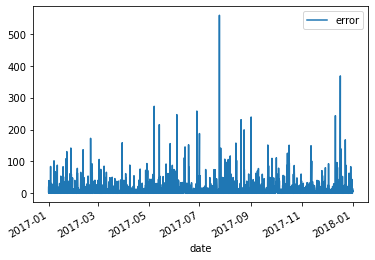

In [70]:
error_df.plot(x="date", y="error")

In [71]:
error_df.sort_values("error", ascending=False).head(100)

,date,error,y,p
1928,2017-07-24 21:00:00+08:00,558.430679,15.243528,38.874666
3349,2017-12-16 20:00:00+08:00,368.190620,22.488992,41.677286
1169,2017-05-07 17:00:00+08:00,272.883581,17.635161,34.154349
1680,2017-06-27 20:00:00+08:00,257.975618,21.465508,37.527127
1450,2017-06-03 19:00:00+08:00,246.866060,16.592062,32.304034
...,...,...,...,...
362,2017-02-08 15:00:00+08:00,65.772106,17.233458,25.343459
27,2017-01-03 11:00:00+08:00,65.679348,19.442914,27.547194
885,2017-04-08 08:00:00+08:00,65.381469,20.183264,28.269144
77,2017-01-09 11:00:00+08:00,65.191080,17.402919,25.477019


In [72]:
error_df[error_df.date.dt.floor('d')=="2017-12-15"]

,date,error,y,p
3331,2017-12-15 01:00:00+08:00,0.571615,49.429061,48.673009
3332,2017-12-15 02:00:00+08:00,0.990417,46.658786,47.653983
3333,2017-12-15 03:00:00+08:00,0.032727,48.401369,48.582274
3334,2017-12-15 05:00:00+08:00,0.022854,46.576803,46.727977
3335,2017-12-15 06:00:00+08:00,1.178121,42.703703,43.789116
3336,2017-12-15 10:00:00+08:00,3.648247,24.189043,22.279004
3337,2017-12-15 11:00:00+08:00,13.007441,17.458932,21.065515
3338,2017-12-15 12:00:00+08:00,2.990753,14.199006,15.928386
3339,2017-12-15 14:00:00+08:00,0.014096,14.713302,14.832030
3340,2017-12-15 15:00:00+08:00,0.053979,13.432269,13.664603


In [73]:
error_df[error_df.date.dt.floor('d')=="2017-12-16"]

,date,error,y,p
3343,2017-12-16 00:00:00+08:00,0.211449,47.285905,47.745742
3344,2017-12-16 02:00:00+08:00,0.603333,49.066754,48.290010
3345,2017-12-16 06:00:00+08:00,2.746746,45.656701,47.314033
3346,2017-12-16 08:00:00+08:00,10.911572,23.930776,27.234043
3347,2017-12-16 15:00:00+08:00,1.719745,15.293246,16.604637
3348,2017-12-16 19:00:00+08:00,238.643117,12.448174,27.896252
3349,2017-12-16 20:00:00+08:00,368.190620,22.488992,41.677286
3350,2017-12-16 21:00:00+08:00,0.252917,36.832385,36.329477
3351,2017-12-16 23:00:00+08:00,57.976362,24.762320,32.376541


In [74]:
error_df[error_df.date.dt.floor('d')=="2017-12-17"]

,date,error,y,p
3352,2017-12-17 01:00:00+08:00,0.849718,46.246695,47.168497
3353,2017-12-17 03:00:00+08:00,0.413085,48.194279,47.551562
3354,2017-12-17 04:00:00+08:00,4.262415,45.052621,47.117182
3355,2017-12-17 12:00:00+08:00,3.253639,43.932414,42.128630
3356,2017-12-17 13:00:00+08:00,1.753347,43.338128,42.013987
3357,2017-12-17 14:00:00+08:00,25.171267,46.737752,41.720655
3358,2017-12-17 15:00:00+08:00,46.435051,44.932318,38.117991
3359,2017-12-17 17:00:00+08:00,139.135985,25.705280,37.500872
3360,2017-12-17 18:00:00+08:00,63.398744,23.237242,31.199575
3361,2017-12-17 20:00:00+08:00,19.615450,44.647373,40.218440


In [75]:
error_df[error_df.date.dt.floor('d')=="2017-07-24"]

,date,error,y,p
1919,2017-07-24 01:00:00+08:00,0.117622,45.760968,46.103929
1920,2017-07-24 03:00:00+08:00,0.387940,46.105985,46.728833
1921,2017-07-24 04:00:00+08:00,4.883362,48.464448,46.254615
1922,2017-07-24 06:00:00+08:00,4.367750,42.851833,44.941750
1923,2017-07-24 08:00:00+08:00,0.892497,16.434848,17.379569
1924,2017-07-24 12:00:00+08:00,2.494568,22.514520,20.935099
1925,2017-07-24 16:00:00+08:00,14.455979,16.209481,20.011583
1926,2017-07-24 17:00:00+08:00,4.333401,14.635949,12.554267
1927,2017-07-24 18:00:00+08:00,0.861769,11.054118,11.982433
1928,2017-07-24 21:00:00+08:00,558.430679,15.243528,38.874666


In [76]:
error_df[error_df.date.dt.floor('d')=="2017-07-25"]

,date,error,y,p
1931,2017-07-25 00:00:00+08:00,0.471129,48.773277,48.086889
1932,2017-07-25 05:00:00+08:00,0.877496,45.930321,46.867069
1933,2017-07-25 09:00:00+08:00,36.407063,22.398858,16.365031
1934,2017-07-25 10:00:00+08:00,43.473354,34.134875,27.541442
1935,2017-07-25 15:00:00+08:00,41.813132,13.006489,19.472796
1936,2017-07-25 16:00:00+08:00,3.857440,17.366688,19.330724
1937,2017-07-25 17:00:00+08:00,4.474437,11.916218,14.031504
1938,2017-07-25 18:00:00+08:00,14.860601,7.993376,11.848321
1939,2017-07-25 20:00:00+08:00,0.008013,36.945837,37.035352
1940,2017-07-25 21:00:00+08:00,0.899038,43.493165,44.441341
